In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymks
import numpy as np
from PIL import Image
from Scripts import SpatialCorrelations as corr
import matplotlib.pyplot as plt
import pandas as pd
import os
from Scripts import velocityCalculations as vel
from Scripts import hoshenKopleman as hosh

In [4]:
path = '/home/sushil/Desktop/AC/output/'
list_of_files = os.listdir(path)
list_of_files.sort()
list_files = []
for i in list_of_files:
    if i[-5:]=='0.dat':
        list_files.append(path+i)
    
img_ = corr.dat_to_numpy(list_files[999])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1

plt.imshow(img_)
plt.colorbar()
plt.title('Original Binary image')
plt.show()
print(np.sum(img_))



TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [33]:
len(list_files)

2000

In [34]:
labels = hosh.hoshenKoplemanLabels(img_)

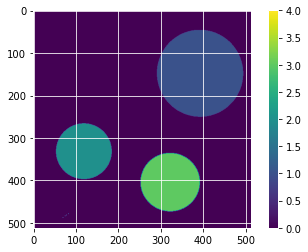

In [35]:
plt.imshow(labels)
plt.colorbar()

In [36]:
np.max(labels)


4

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([4.00000000e+00, 1.08593333e+03, 2.16786667e+03, 3.24980000e+03,
        4.33173333e+03, 5.41366667e+03, 6.49560000e+03, 7.57753333e+03,
        8.65946667e+03, 9.74140000e+03, 1.08233333e+04, 1.19052667e+04,
        1.29872000e+04, 1.40691333e+04, 1.51510667e+04, 1.62330000e+04,
        1.73149333e+04, 1.83968667e+04, 1.94788000e+04, 2.05607333e+04,
        2.16426667e+04, 2.27246000e+04, 2.38065333e+04, 2.48884667e+04,
        2.59704000e+04, 2.70523333e+04, 2.81342667e+04, 2.92162000e+04,
        3.02981333e+04, 3.13800667e+04, 3.24620000e+04]),
 <a list of 1 Patch objects>)

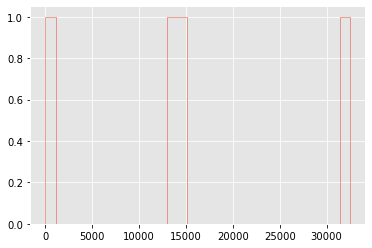

In [37]:
plt.hist(areaDistribution(labels), bins= 30,histtype=u'step')

In [8]:
A = []
for i in range(340):
    img_ = corr.dat_to_numpy(list_files[i*6])
    img_ = vel.gaussian_filter(img_,4)
    img_ = (img_>0.5)*1
    labels = hosh.hoshenKoplemanLabels(img_)
    print(6*i,'th image = ',np.max(labels), ' shapes')
    A.append(np.max(labels))
    

0 th image =  0  shapes
6 th image =  91  shapes
12 th image =  54  shapes
18 th image =  45  shapes
24 th image =  35  shapes
30 th image =  30  shapes
36 th image =  30  shapes
42 th image =  27  shapes
48 th image =  25  shapes
54 th image =  24  shapes
60 th image =  23  shapes
66 th image =  22  shapes
72 th image =  21  shapes
78 th image =  18  shapes
84 th image =  18  shapes
90 th image =  18  shapes
96 th image =  17  shapes
102 th image =  17  shapes
108 th image =  16  shapes
114 th image =  15  shapes
120 th image =  16  shapes
126 th image =  15  shapes
132 th image =  15  shapes
138 th image =  14  shapes
144 th image =  14  shapes
150 th image =  13  shapes
156 th image =  13  shapes
162 th image =  12  shapes
168 th image =  11  shapes
174 th image =  11  shapes
180 th image =  10  shapes
186 th image =  9  shapes
192 th image =  10  shapes
198 th image =  10  shapes
204 th image =  9  shapes
210 th image =  9  shapes
216 th image =  9  shapes
222 th image =  9  shapes

1860 th image =  2  shapes
1866 th image =  2  shapes
1872 th image =  2  shapes
1878 th image =  2  shapes
1884 th image =  2  shapes
1890 th image =  2  shapes
1896 th image =  2  shapes
1902 th image =  2  shapes
1908 th image =  2  shapes
1914 th image =  2  shapes
1920 th image =  2  shapes
1926 th image =  2  shapes
1932 th image =  2  shapes
1938 th image =  2  shapes
1944 th image =  2  shapes
1950 th image =  2  shapes
1956 th image =  2  shapes
1962 th image =  2  shapes
1968 th image =  2  shapes
1974 th image =  2  shapes
1980 th image =  2  shapes
1986 th image =  2  shapes
1992 th image =  2  shapes
1998 th image =  2  shapes


IndexError: list index out of range

Text(0, 0.5, 'Number of ppt')

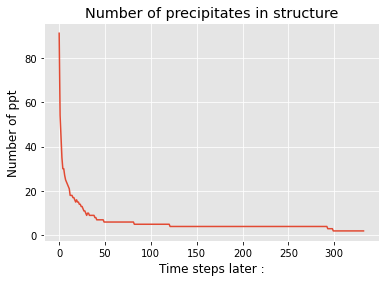

In [9]:
plt.plot(A[1:])
plt.title('Number of precipitates in structure')
plt.xlabel('Time steps later :')
plt.ylabel('Number of ppt')

In [14]:
def areaDistribution(labels):
    A =[]
    noOfLabels = np.max(labels)
    for i in range(1,noOfLabels+1):
        A.append(np.sum((labels==i)*1))
    return A
    

In [15]:
areaDistribution(labels)

[69746, 7771]

# Use the code below to plot area change by considering centre of gravity

In [10]:
A = []
img_ = corr.dat_to_numpy(list_files[1999])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1
labels_199 = hosh.hoshenKoplemanLabels(img_)
uniqueLabels = np.unique(labels_199).tolist()
for i in uniqueLabels[1:]:
    A.append(hosh.precipitateCentres(labels_199,i))
N =[]
for i in range(50):
    img_ = corr.dat_to_numpy(list_files[199-i])
    img_ = vel.gaussian_filter(img_,4)
    img_ = (img_>0.5)*1
    labels = hosh.hoshenKoplemanLabels(img_)
    B = []
    for j in range(12,13):
        labelNumberForThisImage = labels[A[j][0]][A[j][1]]
        numberOfPixels = np.sum((labels==labelNumberForThisImage)*1)
        B.append(numberOfPixels)
    N.append(B)
    print(i)
plt.rcParams["figure.figsize"] = (20,20)
Z = []
for i in range(50):
    Z.append(i+150)
    
for ii in range(50):
    graph = []
    for jj in range(50):
        graph.append(N[jj][ii])
    graph.reverse()
    plt.plot(Z,graph)
plt.title('Area change for each precipitate as time increases')
plt.ylabel('Area')
plt.xlabel('timestep x 500')
      
